# <font color="magenta">Predicción de ventas mensuales.</font>

---


Dataset: AdventureWorks Sales.xlsx 👇

https://github.com/microsoft/powerbi-desktop-samples/blob/main/AdventureWorks%20Sales%20Sample/AdventureWorks%20Sales.xlsx

Predicciones de datos mensuales con Prophet 👇

https://facebook.github.io/prophet/docs/non-daily_data.html#monthly-data


---


### 📈Predicción de ventas de los próximos 3 meses.
Se realizan dos modelos predictivos:
  - **Global**: Predicción de ventas totales.
  - **Bottom-Up**: Predicciones de ventas de cada producto.


---


⇨ Manejo de valores:

  - Global: el valor se manejan tal cual.
  $$V_{Global}$$
      
  - Bottom-Up: los valores se suman.
  $$V_{BottomUp}= V_1+V_2+ ... +V_n = \sum_{k=1}^n V_k$$

  - Top-Down: los valores de Bottom-Up se ajustan.
$$V_{TopDown}= V_1*a+V_2*a+ ... +V_n*a = \sum_{k=1}^n V_k*a$$

>⚠️
>>
>En el mejor de los casos, el valor Global deben de ser igual a la suma de los valores (Bottom-Up).
>>
>$$V_{Global} = V_{BottomUp}$$
>>
>_Sin embargo, en este caso no es así y, por lo tanto, se realiza un ajuste llamado **Top-Down o reconciliación**._ $$V_{Global} = V_{TopDown}$$


---


⇨ Manejo de Errores:

  - Global: el error se maneja tal cual.

$$E_{Global}$$

  - Bottom-Up: promedio de los errores.

$$E_{BottomUp} = ( \sum_{k=1}^n V_k ) /n$$

>⚠️
>>
>_El error Global es menor que el error promedio y, por lo tanto, la predicción Global es más precisa._ $$E_{Global}<E_{BottomUp}$$

# <font color="magenta">Librerías.</font>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from prophet import Prophet
import itertools

# <font color="magenta">Funciones.</font>

In [ ]:
# Medición del error.


def mean_absolute_percentage_error(y_true, y_pred):
        """
        Mide el error de las predicciones.
        MAPE (Error Porcentual Absoluto Medio).

        Input:
            y_true: valor real.
            y_pred: valor predicho.
        Output:
            mape: valor del error.
        """
        mape = float(tf.math.reduce_mean(tf.math.abs((y_true - y_pred) / y_true)) * 100)
        return mape

In [ ]:
# Modelo predictivo con prophet.
def prophet_predict(data):
        """
        Confección de un modelo predictivo de ventas.
        Predice utilizando los parámetros con el menor error.

        Input:
            data: Dataframe con las columnas:
                  ds: fecha.
                  y: cantidad de productos.

        Output:
            best_params: Diccionario con los mejores ajustes.
            best_mape: Error Absoluto Porcentual.
            forecast: Predicciones.
        """

        param_grid = {
            'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
            'seasonality_mode': ['additive', 'multiplicative']
            }


        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        mapes = []  # Almacenamiento de los errores
        hparams = [] # Almacenamiento de los parámetros

        # Entrenamiento del modelo
        for params in all_params:

            prophet_model = Prophet(** params)
            prophet_model.fit(data)
            # Crear un DataFrame con los pronostico de los proximos 3 meses
            future = prophet_model.make_future_dataframe(periods=3 , freq='ME')
            forecast = prophet_model.predict(future)
            mapes.append(mean_absolute_percentage_error(data['y'],forecast['yhat'][:-3]))
            hparams.append([params])

        # Busca y retorna los parámetros con el mínimo error
        tuning_results = pd.DataFrame(hparams)
        tuning_results['MAPE'] = mapes
        tuning_results['MAPE'] = tuning_results['MAPE'].astype('float')
        best_params = tuning_results.loc[tuning_results['MAPE'].idxmin()][0]
        best_mape = tuning_results.loc[tuning_results['MAPE'].idxmin()]['MAPE']

        # Pronóstico de los próximos 3 meses
        prophet_model = Prophet(** best_params)
        prophet_model.fit(data)

        future = prophet_model.make_future_dataframe(periods=3 , freq='ME')
        forecast = prophet_model.predict(future)

        return best_params, best_mape, forecast['yhat'][-3:]

# <font color="magenta">Carga y transformación de los archivos.</font>

In [ ]:
# Productos, Orden de venta, Fechas.
product = pd.read_excel('AdventureWorks Sales.xlsx', sheet_name='Product_data')
soh = pd.read_excel('AdventureWorks Sales.xlsx', sheet_name='Sales_data')
data = pd.read_excel('AdventureWorks Sales.xlsx', sheet_name='Date_data')

In [ ]:
# Selección de columnas.
prod_1 = product[['ProductKey' , 'Product']].copy()
soh_1 = soh[['ProductKey' , 'OrderDateKey' , 'Order Quantity']].copy()
data_1 = data[['DateKey' , 'Date']].copy()

## Cálculo de ventas mensuales.

In [ ]:
# Transformación.
soh_1 = soh_1.merge(data_1, left_on='OrderDateKey', right_on='DateKey')
soh_1.drop(columns=['OrderDateKey', 'DateKey'], inplace=True)
soh_1.head()

,ProductKey,Order Quantity,Date
0,349,1,2017-07-02
1,350,3,2017-07-02
2,351,1,2017-07-02
3,344,1,2017-07-02
4,345,1,2017-07-02


In [ ]:
soh_1['Date'] = pd.to_datetime(soh_1['Date'])
soh_1.head()

,ProductKey,Order Quantity,Date
0,349,1,2017-07-02
1,350,3,2017-07-02
2,351,1,2017-07-02
3,344,1,2017-07-02
4,345,1,2017-07-02


In [ ]:
# Cálculo de cantidades mensuales.
total_sales = soh_1[['Date', 'Order Quantity']].copy()
total_sales.set_index('Date', inplace=True)

total_sales = total_sales.resample('ME').sum()[1:-1]

In [ ]:
total_sales.head()

,Order Quantity
Date,
2017-08-31,2212
2017-09-30,2915
2017-10-31,174
2017-11-30,5438
2017-12-31,188


Text(0.5, 1.0, 'Cantidad de productos vendidos por mes')

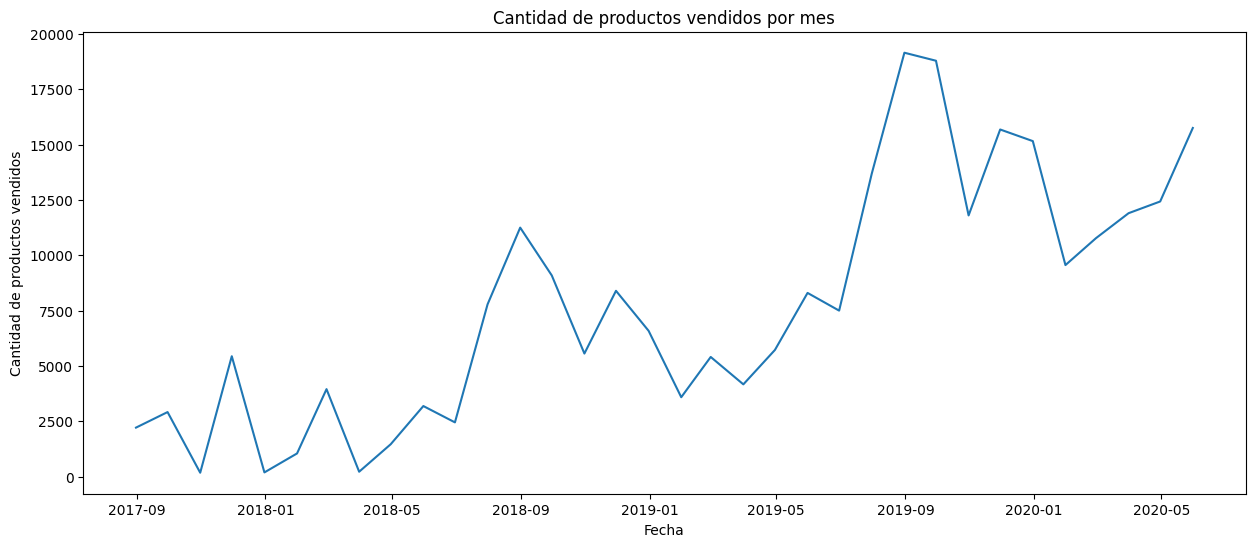

In [ ]:
# Grafica de ventas mensuales.
plt.figure(figsize=(15,6))
plt.plot(total_sales)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de productos vendidos')
plt.title('Cantidad de productos vendidos por mes')

# <font color="magenta">Predicción de las ventas **globales**.</font>
Confección de un modelo para pronosticar las ventas totales mensuales.

In [ ]:
# Cambio de nombre de columnas.
total_sales.reset_index(inplace=True)
total_sales.rename(columns={'Date': 'ds', 'Order Quantity': 'y'}, inplace=True)

In [ ]:
# Cálculo de los parámetros más óptimos.
best_params, best_mape, _ = prophet_predict(total_sales)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcqkz7lc/x7wx0561.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcqkz7lc/cd54chxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51186', 'data', 'file=/tmp/tmptcqkz7lc/x7wx0561.json', 'init=/tmp/tmptcqkz7lc/cd54chxm.json', 'output', 'file=/tmp/tmptcqkz7lc/prophet_model80qb4k_j/prophet_model-20241017190429.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

In [ ]:
# Entrenamiento.
prophet_model = Prophet(** best_params)
prophet_model.fit(total_sales)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcqkz7lc/celrgyo3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcqkz7lc/5ipxg1xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73968', 'data', 'file=/tmp/tmptcqkz7lc/celrgyo3.json', 'init=/tmp/tmptcqkz7lc/5ipxg1xl.json', 'output', 'file=/tmp/tmptcqkz7lc/prophet_modelort5rnp7/prophet_model-20241017190441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:04:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


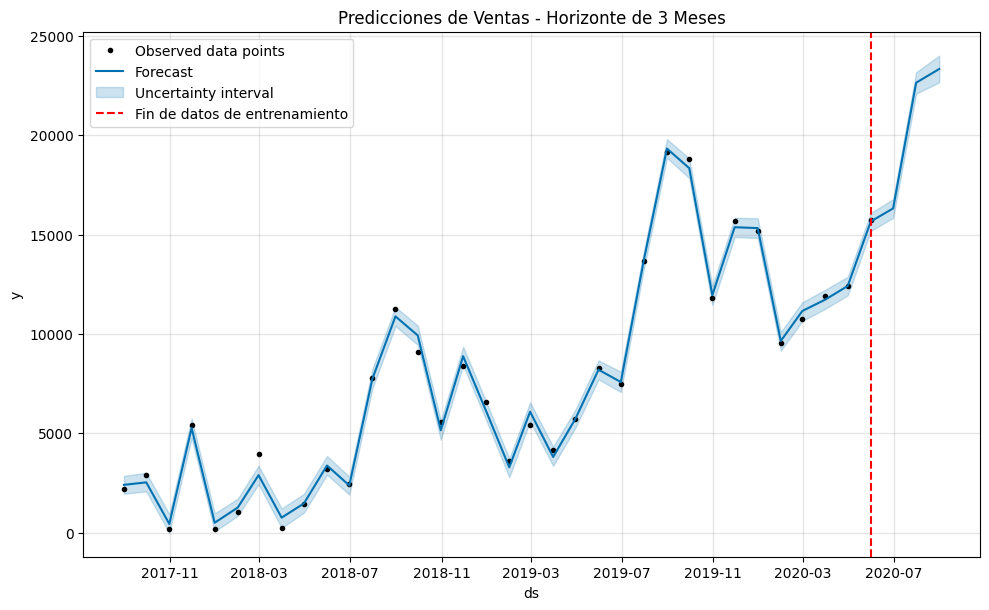

In [ ]:
# Predicción de los próximos 3 meses.
future = prophet_model.make_future_dataframe(periods=3 , freq='ME')
forecast = prophet_model.predict(future)

# Gráfica.
fig = prophet_model.plot(forecast)
plt.axvline(x=total_sales['ds'].max(), color='red', linestyle='--', label='Fin de datos de entrenamiento')
plt.title("Predicciones de Ventas - Horizonte de 3 Meses")
plt.legend()
plt.show()

In [ ]:
# Error del modelo.
Global_mape = best_mape
print(f'Error Absoluto Porcentual: {Global_mape.round(2)}%')

Error Absoluto Porcentual: 21.06%


# <font color="magenta">**Bottom-Up**.</font>
Predicción de la ventas mensuales **por producto**.

In [ ]:
# Última fecha para la predicción.
date_index = soh_1['Date'].max()
date_index = (date_index + pd.offsets.MonthEnd(0) - pd.DateOffset(months=1))+ pd.offsets.MonthEnd(0)
date_index

Timestamp('2020-05-31 00:00:00')

In [ ]:
# Lista de los productos
products_id_list = list(soh_1['ProductKey'].unique())

In [ ]:
product_mounthly_pred = {
        'ProductKey': [],  # Producto.
        'best_params': [], # Mejores ajustes.
        'best_mape': [],   # Error Absoluto Porcentual.
        'mounth_1': [], #Predicción mes 1.
        'mounth_2': [], #Predicción mes 2.
        'mounth_3' : [] #Predicción mes 3.
         }

In [ ]:
product_inpred = [] # Almacenamiento de productos sin predicciones.

# Cálculo de predicciones.
for product_id in products_id_list:

    product_df = soh_1[soh_1['ProductKey'] == product_id].copy()
    product_df.drop(columns='ProductKey', inplace=True)
    product_df.set_index('Date', inplace=True)

    if product_df.index[-1] < date_index:
        product_df = product_df.resample('ME').sum()
        product_df.loc[date_index] = 0
        product_df = product_df.resample('ME').asfreq().fillna(0)
    elif product_df.index[-1] > date_index:
        product_df = product_df.resample('ME').sum()[:-1]
        product_df = product_df.fillna(0)
    else:
        product_df = product_df.resample('ME').sum()
        product_df = product_df.fillna(0)

    product_df.reset_index(inplace=True)
    product_df.rename(columns={'Date': 'ds', 'Order Quantity': 'y'}, inplace=True)

    try:
        best_params, best_mape, pred = prophet_predict(product_df)

        product_mounthly_pred ['ProductKey'].append(product_id)
        product_mounthly_pred ['best_params'].append(best_params)
        product_mounthly_pred ['best_mape'].append(best_mape)

        for j in range(3): # 3 meses.
          if pred.iloc[j] >= 0:
            product_mounthly_pred [f'mounth_{j+1}'].append(pred.iloc[j])
          else:
            product_mounthly_pred [f'mounth_{j+1}'].append(0)

    except:
        product_inpred.append(product_id)
        continue

Se han truncado las últimas 5000 líneas del flujo de salida.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcqkz7lc/1e0pton8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptcqkz7lc/qbtlma40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78385', 'data', 'file=/tmp/tmptcqkz7lc/1e0pton8.json', 'init=/tmp/tmptcqkz7lc/qbtlma40.json', 'output', 'file=/tmp/tmptcqkz7lc/prophet_model_wjrjk4e/prophet_model-20241017185608.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
1

In [ ]:
# Guardar predicciones.
product_mounthly_pred = pd.DataFrame(product_mounthly_pred)

In [ ]:
product_mounthly_pred.to_csv('product_mounthly_pred.csv', index=False)

# <font color="magenta">Análisis de errores.</font>

Se evalúa la diferencia entre los 2 modelos y se comparan los errores.

### Conclusión:
Este modelo de ventas Globales se adapta mejor que el modelo Bottom-Up.

En el apartado siguiente se realizará una adaptación de las predicciones de Bottom-Up para que las cantidades individuales se ajusten respecto a la predicción Global.

### Diferencia entre los 2 modelos predictivos.

*Mediante la fórmula:*

    (abs(Global - Bottom-Up)/ Global) *100

In [ ]:
# Leer las predicciones guardadas.
product_mounthly_pred = pd.read_csv('product_mounthly_pred.csv')

In [ ]:
# Suma de ventas.
mounth_1_total = product_mounthly_pred['mounth_1'].sum()
mounth_2_total = product_mounthly_pred['mounth_2'].sum()
mounth_3_total = product_mounthly_pred['mounth_3'].sum()

In [ ]:
# Errores mensuales.
error_analisis = {
            'sum_prod' : [mounth_1_total, mounth_2_total, mounth_3_total],
            'global' : [forecast['yhat'].iloc[-3], forecast['yhat'].iloc[-2], forecast['yhat'].iloc[-1]],
            }

error_analisis = pd.DataFrame(error_analisis)
error_analisis['MAPE'] = abs((error_analisis['global'] - error_analisis['sum_prod']) / error_analisis['global'])*100
error_analisis

,sum_prod,global,MAPE
0,12220.282016,16320.121936,25.121380
1,12160.795344,22648.937830,46.307436
2,12104.649872,23339.262003,48.136107


La discrepancia entre los 2 modelos aumenta cada mes.

El error (MAPE) tiene un valor cada vez más alto.


In [ ]:
# Guardar Errores.
error_analisis.to_csv('error_analisis.csv', index=False)

### Modelo que mejor se ajusta a los datos reales.

*Comparación entre  los errores del Global y Promedio de Bottom-Up.*

 - El error Global se encuentra el la variable *Global_mape*.
 - El error del Bottom-Up se calcula a traves del promedio de los errores, que se encuentran en el Dataframe *product_mounthly_pred['best_mape']*.

In [ ]:
# Errores Individuales.
mape_mean = product_mounthly_pred['best_mape'].copy()
mape_mean = mape_mean.replace(np.inf, np.nan)
mape_mean = mape_mean.dropna()

In [ ]:
print(f'MAPE Promedio: {mape_mean.mean().round(2)}% \nMAPE Global: {Global_mape.round(2)}%')

MAPE Promedio: 144.4% 
MAPE Global: 21.06%


El error Global es menor que el error de Bottom-Up y por lo tanto, tiene un mejor desempeño en las predicciones.

# <font color="magenta">**Top-Down**.</font>

Teniendo en cuenta que la predicción Global es más precisa.

El objetivo es predicir las ventas de cada producto, partiendo de la predicción Global y ajustando los valores de Bottom-Up.

Como resultado, las ventas por producto se asemejan más a la predicción Global.

In [ ]:
# Reconciliación.
sum_prod = [mounth_1_total, mounth_2_total, mounth_3_total]

for mounth in range(3):
    adjustment_factor = forecast['yhat'].iloc[-3 + mounth] / sum_prod[mounth]
    product_mounthly_pred[f'mounth_{mounth+1}_adjusted'] = 0
    # Columnas co las cantidades ajustadas
    for i,r in product_mounthly_pred.iterrows():
      product_mounthly_pred[f'mounth_{mounth+1}_adjusted'][i] = round(product_mounthly_pred.iloc[i,3+mounth] * adjustment_factor , 0)


In [ ]:
product_mounthly_pred.tail()

,ProductKey,best_params,best_mape,mounth_1,mounth_2,mounth_3,mounth_1_adjusted,mounth_2_adjusted,mounth_3_adjusted
345,485,"{'changepoint_prior_scale': 0.5, 'seasonality_...",6.496321,227.457133,241.190953,254.924773,304,449,492
346,536,"{'changepoint_prior_scale': 0.5, 'seasonality_...",32.239285,93.739064,92.486057,91.233051,125,172,176
347,489,"{'changepoint_prior_scale': 0.5, 'seasonality_...",19.842104,39.255596,40.196495,41.137393,52,75,79
348,535,"{'changepoint_prior_scale': 0.5, 'seasonality_...",123.516256,76.226929,76.599847,76.972765,102,143,148
349,228,"{'changepoint_prior_scale': 0.5, 'seasonality_...",34.730320,50.174674,52.415225,54.655776,67,98,105


In [ ]:
# Suma mensual.
mounth_1_total_adjust = product_mounthly_pred['mounth_1_adjusted'].sum()
mounth_2_total_adjust = product_mounthly_pred['mounth_2_adjusted'].sum()
mounth_3_total_adjust = product_mounthly_pred['mounth_3_adjusted'].sum()

print(f'Ajuste mes 1: {mounth_1_total_adjust}')
print(f'Ajuste mes 2: {mounth_2_total_adjust}')
print(f'Ajuste mes 3: {mounth_3_total_adjust}')

Ajuste mes 1: 16318
Ajuste mes 2: 22647
Ajuste mes 3: 23336


In [ ]:
# Errores mensuales.
error_analisis_adjust = {
            'sum_prod_ajust' : [mounth_1_total_adjust, mounth_2_total_adjust, mounth_3_total_adjust],
            'global' : [forecast['yhat'].iloc[-3], forecast['yhat'].iloc[-2], forecast['yhat'].iloc[-1]],
            }

error_analisis_adjust = pd.DataFrame(error_analisis_adjust)
error_analisis_adjust['MAPE'] = abs((error_analisis_adjust['global'] - error_analisis_adjust['sum_prod_ajust']) / error_analisis_adjust['global'])*100
error_analisis_adjust

,sum_prod_ajust,global,MAPE
0,16318,16320.121936,0.013002
1,22647,22648.937830,0.008556
2,23336,23339.262003,0.013976


Con el ajuste, los valores Globales y las sumatorias son mínimas (aprox. 0%)

# <font color="magenta">Conclusión.</font>

Tanto el método **Bottom-Up** como **Top-Down** tienen como objetivo determinar cuantas cantidades de un producto se venderán en los próximos 3 meses; sin embargo...

"*El método **Top-Down** tiene mejor desempeño para predecir las ventas.*"